In [74]:
import pandas as pd
import numpy as np

ts_restaurants = [
    'kimos-maui-lahaina',
    'leilanis-lahaina-2',
    'hula-grill-kaanapali-lahaina-2',
    'sunnyside-tahoe-city-2',
    'dukes-huntington-beach-huntington-beach-2',
    'dukes-la-jolla-la-jolla',
    'dukes-malibu-malibu-2',
    'dukes-beach-house-lahaina',
    'dukes-kauai-lihue-3',
    'dukes-waikiki-honolulu-2',
    'hula-grill-waikiki-honolulu-3',
    'keokis-paradise-koloa',
]

filepath = '../../data/processed/hi_rws_0001_0256_final.csv'
df =pd.read_csv(filepath)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195769 entries, 0 to 195768
Data columns (total 28 columns):
alias               195769 non-null object
ratingValue         195769 non-null int64
dataPublished       195769 non-null object
description         195769 non-null object
author              195769 non-null object
sentiment           195769 non-null int64
word_count          195769 non-null int64
sent_count          195769 non-null int64
chr_count           195769 non-null int64
avg_word_len        195769 non-null float64
avg_sent_len        195769 non-null float64
num_of_stopwords    195769 non-null int64
num_of_modals       195769 non-null int64
hashtags            195769 non-null int64
mentions            195769 non-null int64
numerics            195769 non-null int64
uppercase_cnt       195769 non-null int64
punctuation_cnt     195769 non-null int64
vocab_cnt           195769 non-null int64
ratio_lexical       195769 non-null float64
ratio_content       195769 non-null flo

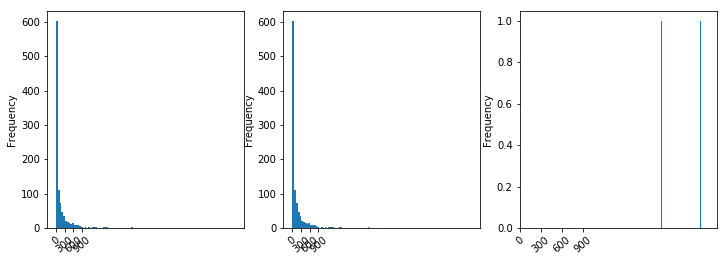

In [288]:
# distribution of restaurants on number of reviews
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
(df_all, df_otr, df_tsr)
for ax, df_temp in zip((ax1, ax2, ax3), (df_all, df_otr, df_tsr)):
    df_temp.groupby('alias').count().ratingValue.sort_values()\
    .plot('hist', bins=100, xticks=range(0, 1000, 300), rot=40, ax=ax)

In [2]:
len(df.alias.unique())

1023

In [91]:
# businesses that has more than 50 reviews
pd_more_than_N_index = (df.groupby('alias').alias.count() > 50)
more_than_N = pd_more_than_N_index[pd_more_than_N_index == True].index
more_than_N

Index(['1054togoshi-kihei', '5-palms-restaurant-kihei-2',
       '808-antojitos-lahaina', '808-deli-kihei', '808-grindz-cafe-lahaina-2',
       '808-on-main-wailuku', '808-plates-maui-kahului',
       'a-saigon-cafe-wailuku', 'aa-roots-lahaina-5', 'abc-store-kihei-4',
       ...
       'waikapu-on-30-wailuku', 'wailea-beach-wailea-makena',
       'wailea-golf-club-wailea', 'wailele-luau-lahaina-2',
       'wailuku-coffee-company-wailuku', 'whales-tale-wailea-3',
       'what-ales-you-kihei', 'wow-wee-mauis-kava-bar-and-grill-kahului',
       'yogurtland-lahaina', 'zippys-kahului-kahului'],
      dtype='object', name='alias', length=455)

In [93]:
# ts restaurants only
more_than_N[more_than_N.isin(ts_restaurants)]

Index(['dukes-beach-house-lahaina', 'hula-grill-kaanapali-lahaina-2',
       'kimos-maui-lahaina', 'leilanis-lahaina-2'],
      dtype='object', name='alias')

In [266]:
# scaling trials and comparisons
from sklearn.preprocessing import MinMaxScaler, StandardScaler
sc = StandardScaler()
mm = MinMaxScaler(feature_range=(-1, 1))

scaling_list = []
X = df.groupby('topic_score').mean().sentiment_score.values.reshape(-1, 1)
scaling_list.append(X)
scaling_list.append(sc.fit_transform(X))
scaling_list.append(mm.fit_transform(X))
scaling_list.append(np.vectorize(lambda x: (x*2)-1)(X))
pd.DataFrame(
    data=[i.reshape(1, len(X))[0] for i in scaling_list],
    index=['orginal', 'stdscal', 'minmax', '-1_1']
).transpose().rename(index=str)

,orginal,stdscal,minmax,-1_1
0,0.801150,0.241384,0.238895,0.602300
1,0.854006,0.787706,0.649411,0.708013
2,0.693043,-0.876008,-0.600734,0.386085
3,0.899147,1.254276,1.000000,0.798294
4,0.641635,-1.407358,-1.000000,0.283269


## Division of Categories

- All Businesses
- TS vs Others
- TS only

In [299]:
df_all = df
df_tsr = df[df.alias.isin(ts_restaurants) == True]
df_otr = df[df.alias.isin(ts_restaurants) == False]
dfs = [df_all, df_tsr, df_otr]

In [307]:
[len(i) for i in dfs]

[195769, 9097, 186672]

In [217]:
# adjust sentiment score
adjusted_sent_func = lambda x: (x*2)-1

# helpful for plotting 
plot_params = dict(subplots=False, ylim=(-1,1), rot=45, figsize=(9, 6))

## Results Charts for All Categories

### Topic Sentiment Scores

In [401]:
# ts vs others
df.groupby(by=[df.alias.isin(ts_restaurants), 'topic_score'], as_index=False).sentiment_score.mean()# .apply(lambda x: adjusted_sent_func(x)).unstack(level=1).plot(kind='bar')

,topic_score,sentiment_score
0,0,0.803533
1,1,0.855772
2,2,0.696170
3,3,0.900804
4,4,0.641940
5,0,0.740764
6,1,0.820366
7,2,0.631505
8,3,0.857143
9,4,0.635900


In [388]:
df.groupby(by=df.topic_score).mean().loc[:,['sentiment_score']]

,sentiment_score
topic_score,
0,0.801150
1,0.854006
2,0.693043
3,0.899147
4,0.641635


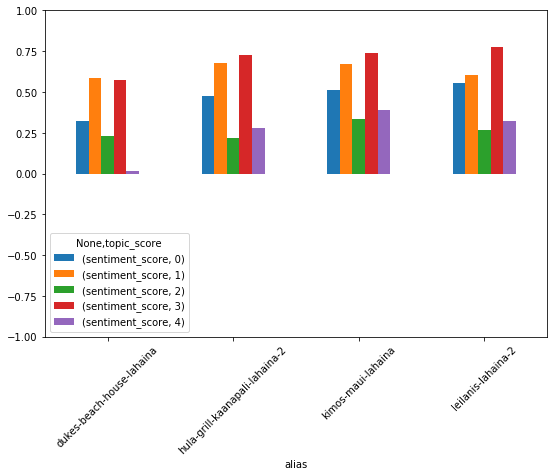

In [260]:
columns = [f'topic_{i}' for i in range(5)]
columns.extend('topic_score')
pd_sent_topics = df[df.alias.isin(ts_restaurants)].groupby(['topic_score', 'alias'])\
.mean().loc[:,['sentiment_score']].apply(lambda x: adjusted_sent_func(x))
pd_sent_topics.unstack(level=0).plot(kind='bar', **plot_params)

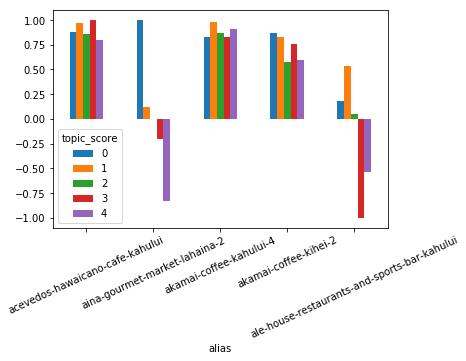

In [184]:
pd_alias_topic = df.groupby(['alias','topic_score']).mean().loc[more_than_N[10:15],['sentiment_score']]
pd_alias_topic['sent_adjusted'] = pd_alias_topic.sentiment_score.apply(lambda x: (x*2)-1)
pd_alias_topic.sent_adjusted.unstack(level=1).plot(kind='bar', subplots=False, rot=25)

In [297]:
df.groupby(['topic_score']).sentiment_score.agg([np.sum, np.mean, np.std])

,sum,mean,std
topic_score,,,
0,34274,0.801150,0.399140
1,62743,0.854006,0.353102
2,20381,0.693043,0.461239
3,10119,0.899147,0.301147
4,24932,0.641635,0.479526
